# In-context data-driven control by estimating open-loop system dynamics using DMD-control

Ayush Pandey

Date: March 26, 2025


## System examples
In this notebook, I will show a DMD-control driven predictive control with different number of context examples. The system we consider is: $x(k+1) = Ax(k) + Bu(k)$, where $k$ is the discrete system time step. 

## Data-driven in-context predictions using estimates of $A$ and $B$
Assume that we collect data from the input-controlled system defined above: $(X, X', U)$. Here, $X$ is stacked observations until time $k-1$, X' includes the last observation until time $k$, and $U$ is the vector of control inputs. With these observations, our goal (in this example) is to predict the future states $x$ by learning from the given data from the forced system response. We do not know the system matrices $A$, $B$, and have no information about the control signals $u$. So, the prediction task is:

For each context length $l \in [1, 2, ..., L]$ at a given time point $s > L$, we predict:

$(x_{s-l}, x_{s-l+1}, ..., x_s) \rightarrow \hat{x}_{s+1}, ..., \hat{x}_{T}$.

Then, we forward predict for this context length $l$ until time $T > s$. In this example, after estimating the $A$ and $B$ matrices using DMD-control, we compute an LQR controller for the estimated system to get all future predictions.

We study the performance of DMD control in in-context prediction accuracy with number of context examples. For this example, we consider an unstable system and we apply a randomly generated set of input signals to generate the data for the forced system ($x(k+1) = Ax(k) + Bu(k)$).

In [219]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 2, 
                     'ytick.major.size': 6, 'ytick.major.width': 2}
                    )
# same updates global for plotly: font size, xtick and ytick size, and axes lw
px.defaults.template = "plotly_dark" 
import control as ct

### Linear scalar unstable system (with stabilizing control)
We use a linearized system dynamics to generate the data to train the DMD-control method. For this, we define an unstable system 

$x' = Ax + Bu$, and 

$y = Cx$ 

with 

$A = \begin{bmatrix}1 & 0 \\ 0 & 0.15 \end{bmatrix}$

with control over the unstable state through the $B$ matrix:

$B = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$

and, setting identity $C$ matrix so that we can observe both states to record the available training data,

$C = \begin{bmatrix}1 & 0 \\ 0 & 1\end{bmatrix}$

We set an arbitrary initial condition $x_0 = \begin{bmatrix} 5 \\ 1 \end{bmatrix}$ and a randomly generated set of input signals to create arbitrary forced response that will be used to learn the system dynamics.

Note that the DMD method cannot access the matrices $A, B$ or the control signals $u$. We will only use the data measurements in-context to control the system here as defined above. Start by defining and simulating the system to generate the data.

## Generate data

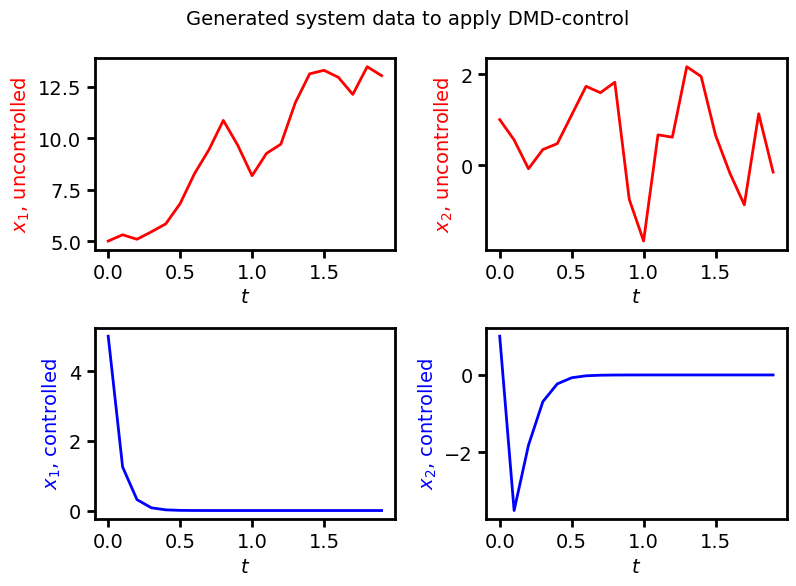

In [220]:
# DMD-control
n = 2
A = np.array([[1, 0], [0, 0.25]])
B = np.array([[1], [1]])
C = np.array([[1, 0], [0, 1]])
D = 0
sys_ol = ct.ss(A, B, C, D, dt=0.1) # open loop
x0 = [5, 1]
t = np.arange(0, 2, 0.1)
U_values = np.random.randn(len(t), 1).T
t, y_gt_ol = ct.forced_response(sys_ol, t, U_values, x0)
K = np.array([[0.75], [0]]).T # control law
sys_cl = ct.ss(A-B@K, [0,0], C, D, dt=0.1) # closed loop
t, y_gt_cl = ct.initial_response(sys_cl, t, x0)
fig, ax = plt.subplots(2,2, figsize=(8, 6))
ax[0,0].plot(t, y_gt_ol[0,], lw=2, c='r')
ax[0,1].plot(t, y_gt_ol[1,], lw=2, c='r')
ax[0,0].set_ylabel('$x_1$, uncontrolled', c='r')
ax[0,0].set_xlabel('$t$')
ax[0,1].set_xlabel('$t$')
ax[0,1].set_ylabel('$x_2$, uncontrolled', c='r')
ax[1,0].plot(t, y_gt_cl[0,], lw=2, c='b')
ax[1,1].plot(t, y_gt_cl[1,], lw=2, c='b')
ax[1,0].set_ylabel('$x_1$, controlled', c='b')
ax[1,0].set_xlabel('$t$')
ax[1,1].set_xlabel('$t$')
ax[1,1].set_ylabel('$x_2$, controlled', c='b')
fig.suptitle('Generated system data to apply DMD-control', fontsize=14)
plt.tight_layout()
plt.show()

In [221]:
# Example of how to create all data matrices (an example with l = 4 context length)
# Use open loop data to identify A and B matrices
Gamma = U_values[:, :2]
X = y_gt_ol[:, :2]
X_prime = y_gt_ol[:, 1:3]
print("X is:")
print(X)
print("X' is:")
print(X_prime)
print("Gamma is:")
print(Gamma)

X is:
[[5.         5.30428503]
 [1.         0.55428503]]
X' is:
[[ 5.30428503  5.08596227]
 [ 0.55428503 -0.0797515 ]]
Gamma is:
[[ 0.30428503 -0.21832275]]


Some plotting utility code below 

In [222]:
# Plot code
def plot_sys_response(figure_objects, t, y_gt, **kwargs):
    fig1, fig2 = figure_objects
    name = kwargs.get('name', 'x')
    color = kwargs.get('color', 'blue')
    # add scatter points on top of the lines with same color dots with black boundary within same trace
    fig1.add_trace(
        go.Scatter(
            x=t,
            y=y_gt[0,],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=2),
            marker=dict(
                color=color,
                line=dict(color="black", width=1),
                size=6
            )
        )
    )
    fig2.add_trace(
        go.Scatter(
            x=t,
            y=y_gt[1,],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=2),
            marker=dict(
                color=color,
                line=dict(color="black", width=1),
                size=6
            )
        )
    )
    return fig1, fig2

In [223]:
T = len(t)
points = np.linspace(0.5, 1.0, T)
color_list = px.colors.sample_colorscale(px.colors.sequential.GnBu, points)
M_icl = T//2 # set max number in-context length to be half of the total time points
M_icl = 5  # Use this to test fixed number of in-context length
m_p = T - M_icl # the size of prediction window

fig1 = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()
 
def compute_dmd_control(X, X_prime, Gamma):
# def compute_dmd_control(X, X_prime):
    """Computed the approximate system matrices A and B using DMD-control.

    Args:
        X (np.ndarray): The data matrix X consisting of state observations.
        X_prime (np.ndarray): The data matrix X' consisting of state observations.
                             advanced in time by one time step.
        Gamma (np.ndarray): The control input snapshots consisting of u values
                            corresponding to the state observations in X.
    Returns:
        A_approx (np.ndarray): The A matrix of the approximate system Ax + Bu.
        B_approx (np.ndarray): The B matrix of the approximate system Ax + Bu.
    """
    # get system dimension n from X
    n = X.shape[0]
    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    S_inv = np.diag(1/S)
    Omega = np.vstack((X, Gamma))
    U_tilde, S_tilde, Vh_tilde = np.linalg.svd(Omega,
                                               full_matrices=False)
    S_tilde_inv = np.diag(1/S_tilde)
    U_1_tilde = U_tilde.T[:, :n].T
    U_2_tilde = U_tilde.T[:, n:].T
    # assert that U_1_tilde and U_2_tilde are correctly partitioned
    assert np.allclose(np.hstack((U_1_tilde.T, U_2_tilde.T)).T, U_tilde)
    A_approx = X_prime @ Vh_tilde.T @ S_tilde_inv @ U_1_tilde.T
    B_approx = X_prime @ Vh_tilde.T @ S_tilde_inv @ U_2_tilde.T
    A_approx_cl = (X_prime)@Vh.T@S_inv@U.T
    return A_approx, B_approx, A_approx_cl

mse_list = []
LQR_Q = np.eye(2)
LQR_R = np.eye(1)
for i in range(M_icl):
    # context data X and X' and Gamma 
    # for (i+1)-examples in the past
    X = y_gt_ol[:, M_icl-i-1:M_icl]
    X_prime = y_gt_ol[:, M_icl-i:M_icl+1]
    Gamma = U_values[:, M_icl-i-1:M_icl]
    A_approx, B_approx, A_approx_cl = compute_dmd_control(X, X_prime, Gamma)
    # forward prediction for the next m_p points
    # we set C = identity to observe all states 
    # in the simulation of this approximated system
    ol_sys = ct.ss(A_approx, B_approx, np.eye(2), 0, dt=0.1)
    # start predicting from the last point in the context until the end of the prediction window
    context_timepoints = t[M_icl-i-1:M_icl]
    prediction_timepoints = t[M_icl:M_icl+m_p]
    starting_x = X_prime[:,-1].reshape(-1,1)
    # Design an LQR controller for the open loop
    K, _, cl_eig = ct.lqr(ol_sys, LQR_Q, LQR_R)
    # get the predicted state
    cl_sys = ct.ss(ol_sys.A-ol_sys.B@K, [0,0], np.eye(2), 0, dt=0.1)
    t_sim, y_pred = ct.initial_response(cl_sys, prediction_timepoints, starting_x)
    color = color_list[i]
    fig1, fig2 = plot_sys_response((fig1, fig2), prediction_timepoints,
                                   y_pred, name=f'n_icl={i+1}', color=color)
    # ground truth
    K_ideal = ct.lqr(sys_ol, LQR_Q, LQR_R)[0]
    cl_sys_ideal = ct.ss(sys_ol.A-sys_ol.B@K_ideal, [0,0], np.eye(2), 0, dt=0.1)
    t_sim, y_pred_ideal = ct.initial_response(cl_sys_ideal, t[M_icl:], X_prime[:, -1])
    loss = y_pred - y_pred_ideal
    mse = np.mean(loss**2)
    mse_list.append(mse)

fig1, fig2 = plot_sys_response((fig1, fig2), t[M_icl:], y_pred_ideal,
                               name='Ideal closed loop', color='red')
# plot MSE
# fig3.add_trace(go.Scatter(x=np.arange(1, M_icl+1), y=mse_list, 
#                           mode='lines+markers', name='MSE', line=dict(color='blue', width=2)))
# plot MSE in log scale
fig3.add_trace(go.Scatter(
    x=np.arange(1, M_icl + 1),
    y=mse_list,
    mode='lines+markers',
    name='MSE',
    line=dict(color='red', width=2)
))
fig3.update_yaxes(type="log")
fig3.update_layout(title='MSE (log-scale) vs. in-context length', 
                   xaxis_title='In-context length', yaxis_title='MSE')

fig1.update_layout(title='DMD-control: x_1', xaxis_title='t', yaxis_title='x_1')
fig2.update_layout(title='DMD-control: x_2', xaxis_title='t', yaxis_title='x_2')
fig1.show()
fig2.show()
fig3.show()